In [1]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import math
from math import sin as sin
from math import cos as cos
import time

In [2]:
def f_x(state, dt):
    """
    Zustandsübergangsfunktion.
    Da die Geschwindigkeit konstant ist und der Zustand nur die Position beinhaltet,
    hat diese Funktion einfach die Geschwindigkeit zur Position hinzugefügt.
    TODO: Später Orientierungswinkel rein (und Winkel in der Messfunktion beachten)
    """  
    x, y, vx, vy = state

    # Update position with current velocity
    new_x = x + vx * dt
    new_y = y + vy * dt

    # Speed stays constant (no acceleration yet)
    new_vx = vx
    new_vy = vy

    return np.array([new_x, new_y, new_vx, new_vy])

In [3]:
def h_x(state):
    """
    Messfunktion.
    Bildet den Zustandsraum (Position und Geschwindigkeit des Schiffs)
    auf den Messraum ab (Winkel von den Funktürmen), wobei definiert als:
    - Norden als 0°, 
    - Osten als 270°,
    - Süden als 180°,
    - Westen als 90°.
    """
    x, y, _, _ = state
    
    beacon0_pos = np.array([-10, 0])
    beacon1_pos = np.array([10, 0])

    # Calculate angle (from ship to beacons; radians to angle)
    angle0 = np.arctan2(beacon0_pos[1] - y, beacon0_pos[0] - x) * 180 / np.pi
    angle1 = np.arctan2(beacon1_pos[1] - y, beacon1_pos[0] - x) * 180 / np.pi

    # Adjust angles to defined orientation (also implement orientation angle later)
    angle0 = (angle0 + 270) % 360
    angle1 = (angle1 + 270) % 360

    return np.array([angle0, angle1])

In [4]:
# Berechne die echten Status der ersten 10 Sekunden, das Schiff fährt Kurven, Geschwindigkeit nicht konstant
dT = 0.1 # 0.1 sec
beacon0_pos = np.array([-10, 0])
beacon1_pos = np.array([10, 0])

states = [] # pos_x, pos_y, vel_x, vel_y (constatn velocity model, actually not, because direction is changing)

for i in range(1000):
    states.append(np.array([5 * sin(i * dT), -10 + 2 * i * dT, 0, 0]))

In [5]:
# Berechne die verrauschten Messdaten

std_0 = 0.75
std_1 = 1.0

np.random.seed(int(time.time()))

zs = []

for i in range(1000):
    state = h_x(states[i]) # winkel beacon0, winkel beacon_1
    zs.append([state[0] + np.random.randn() * std_0, state[1] + np.random.randn() * std_1])

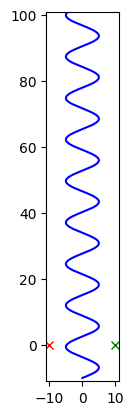

In [6]:
# visualisiere echten Zustand

x_val = [s[0] for s in states]
y_val = [s[1] for s in states]

fig, ax = plt.subplots()
plt.xlim(-11, 11)
plt.ylim(-11, 101)
ax.set_aspect('equal')

plt.plot(x_val, y_val, color = 'blue')

plt.plot(beacon0_pos[0], beacon0_pos[1], marker = 'x', color='red')
plt.plot(beacon1_pos[0], beacon1_pos[1], marker = 'x', color='green')

plt.show()

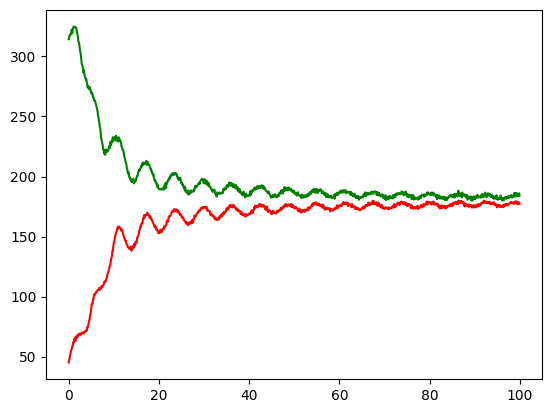

In [7]:
# visualisiere messdaten (diese sind verrauscht)

beacon0_val = [z[0] for z in zs]
beacon1_val = [z[1] for z in zs]
t = [(i * dT) for i in range(1000)]

plt.plot(t, beacon0_val, color = 'red')
plt.plot(t, beacon1_val, color = 'green')
plt.show()

In [8]:
# UKF

sigmas = MerweScaledSigmaPoints(4, alpha = 0.1, beta = 2.0, kappa = 1.0)

ukf = UKF(dim_x = 4, dim_z = 2, fx = f_x, hx = h_x, dt = dT, points = sigmas)

ukf.x = states[0].copy()
ukf.R = np.diag([std_0 ** 2, std_1 ** 2])
ukf.Q = Q_discrete_white_noise(dim=2, dt=dT, var=0.02, block_size=2, order_by_dim=False)

print(ukf.R)
print(ukf.Q)

[[0.5625 0.    ]
 [0.     1.    ]]
[[5.e-07 0.e+00 1.e-05 0.e+00]
 [0.e+00 5.e-07 0.e+00 1.e-05]
 [1.e-05 0.e+00 2.e-04 0.e+00]
 [0.e+00 1.e-05 0.e+00 2.e-04]]


In [9]:
# bereche position mit UKF

uxs = []

temp = ukf.x.copy()

for z in zs:

    ukf.predict()
    ukf.update(z)

    """
    # update die Geschwindigkeit, basierend auf der vorherigen Position
    ukf.x[2] = (ukf.x[0] - temp[0]) * dT # ukf.dT gibts nicht?
    ukf.x[3] = (ukf.x[1] - temp[1]) * dT
    temp = ukf.x.copy()
    print(temp)
    #"""

    uxs.append(ukf.x.copy())
    print(ukf.x.copy())

uxs = np.array(uxs)

[-9.61211139e-02 -9.86471676e+00 -9.51616477e-03  1.33932864e-02]
[ 0.24223659 -9.81812726  0.66550798  0.23779267]
[ 0.64681096 -9.80273562  1.72539994  0.35224068]
[ 1.12445824 -9.56829528  2.74059818  1.06007932]
[ 1.62864885 -9.34846356  3.40609548  1.40958028]
[ 2.11961762 -8.94914218  3.78446775  2.06561255]
[ 2.66032039 -8.76820453  4.1380519   2.00729852]
[ 3.14410497 -8.64923054  4.27634536  1.84413838]
[ 3.37083871 -8.27331344  3.91861972  2.19172307]
[ 3.77078901 -8.13008736  3.93637621  2.06987951]
[ 4.1868455  -7.85604056  3.96347951  2.1663416 ]
[ 4.55520932 -7.71189786  3.93222046  2.07089729]
[ 4.89617443 -7.44387807  3.86331811  2.15046285]
[ 5.19807549 -7.14754504  3.75983138  2.25099027]
[ 5.38857965 -6.98609598  3.56482656  2.19632483]
[ 5.47674801 -6.92132416  3.30334966  2.05965119]
[ 5.66363627 -6.67413103  3.15982281  2.11125792]
[ 5.80259749 -6.44779445  2.99323603  2.14003932]
[ 5.80874963 -6.26753299  2.73325545  2.13553571]
[ 5.79105915 -6.11116029  2.486532

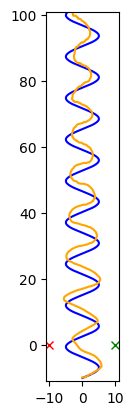

In [10]:
# visualisiere gefilterten Zustand

x_val = [s[0] for s in states]
y_val = [s[1] for s in states]

ux_val = [s[0] for s in uxs]
uy_val = [s[1] for s in uxs]

fig, ax = plt.subplots()
plt.xlim(-11, 11)
plt.ylim(-11, 101)
ax.set_aspect('equal')

plt.plot(x_val, y_val, color = 'blue')
plt.plot(ux_val, uy_val, color = 'orange')

plt.plot(beacon0_pos[0], beacon0_pos[1], marker = 'x', color='red')
plt.plot(beacon1_pos[0], beacon1_pos[1], marker = 'x', color='green')

plt.show()

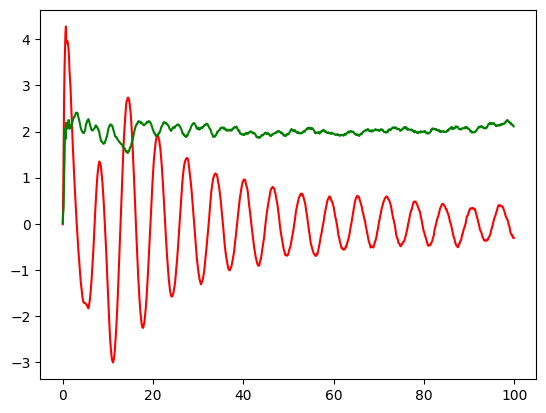

In [13]:
# visualisiere berechnete Geschwindigkeit

vx = [s[2] for s in uxs]
vy = [s[3] for s in uxs]

plt.plot(t, vx, color = 'red')
plt.plot(t, vy, color = 'green')
plt.show()

In [12]:
# Fragen
"""
Warum kann ich in f_x keine Geschwindigkeit hardcoden? -> UKF stürtzt ab

Warum passt die UKF die Geschwindigkeit überhaupt an? -> in f_x wird immer nur der vorherige Wert in die Vorhersage geschrieben

Wenn dem UKF eh egal ist, welche Geschwindigkeit ich in f_x berechne, verschärft das Frage 1 !

Warum kann ich die Geschwingkeit nicht manuel anpassen? -> siehe oben im Code

"""

'\nWarum kann ich in f_x keine Geschwindigkeit hardcoden? -> UKF stürtzt ab\n\nWarum passt die UKF die Geschwindigkeit überhaupt an? -> in f_x wird immer nur der vorherige Wert in die Vorhersage geschrieben\n\nWenn dem UKF eh egal ist, welche Geschwindigkeit ich in f_x berechne, verschärft das Frage 1 !\n\nWarum kann ich die Geschwingkeit nicht manuel anpassen? -> siehe oben im Code\n\n'